# Clustering for gevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class', 'gev_1FGL_Name', 'gev_CLASS1', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/gevsimbad_normalized.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,0.016565,0.318116,0.116714,0.194982,0.353622,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
1,0.000004,0.000080,0.000017,0.000040,0.000080,0.0,0.000087,0.000036,0.000081,0.000102,...,0.0,0.000044,0.000123,0.000141,0.0,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
2,0.014351,0.087269,0.096480,0.058873,0.082640,0.0,0.000042,0.000023,0.000179,0.000817,...,0.0,0.000000,0.000000,0.000000,0.0,b'UCAC2 5051621',Be,b' ',b'spp ',0
3,0.054146,0.123705,0.442960,0.121311,0.188794,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
4,0.046428,0.232212,0.271011,0.145261,0.304359,0.0,0.000000,0.000028,0.000026,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [7]:
def build_images(spectra_distances, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300):
    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])

    plt.subplots(figsize=(18, 6))
    plt.subplot(131)
    plt.title("PCA")
    pca = PCA(n_components=2, random_state=42)
    spectra_2D = pca.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(132)
    plt.title("TSNE, Euclidean distance")
    tsne = TSNE(n_components=2, random_state=42, learning_rate=TSNE_learning_rate, n_iter=TSNE_n_iter)
    spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(133)
    plt.title("TSNE, Chosen distance")
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=TSNE_learning_rate2)
    spectra_2D = tsne.fit_transform(spectra_distances)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    plt.show()
    
    
    # visualization - tsne with chosen distance
    print('Clustering')
    plt.subplots(figsize=(18, 12))
    plt.subplot(3, 3, 1)

    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    plt.title("true labels")
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    for n in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(spectra_distances)

        plt.subplot(3, 3, n)
        c = [colors[l] for l in cluster_labels]
        plt.title("cluster labels ({} clusters)".format(n))
        plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.show()
    
def print_clusters_structure(spectra_distances, n):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)
    centers = []

    spectra['KMeans_clusters_' + str(n)] = cluster_labels
    for i in range(n):
        print("{} cluster".format(i))
        display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])
        centers.append(spectra.loc[spectra['KMeans_clusters_' + str(n)] == i, spectrum_columns].mean(axis=0).values)
    centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)
    del spectra['KMeans_clusters_' + str(n)]

    # centroids
    print("centroids:")
    display(centers)
    # plt.figure(figsize=(20, 10))
    # sns.heatmap(centers, vmin=0, vmax=1)
    # plt.show()

* ### earth mover's distance

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


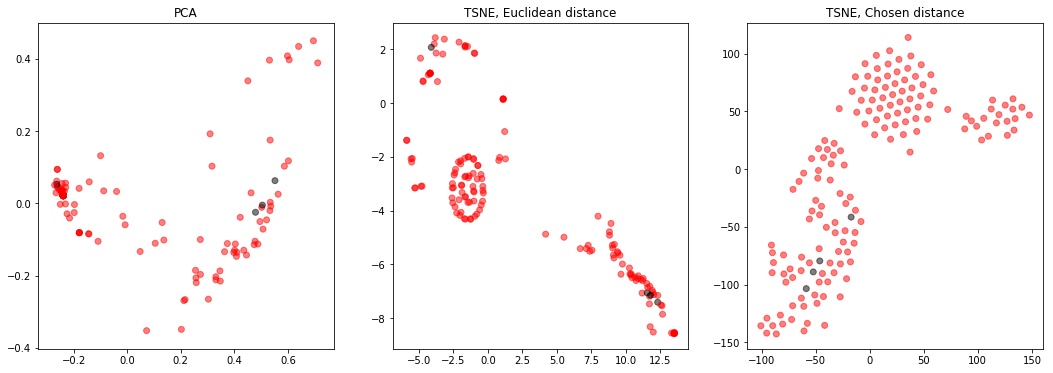

Clustering


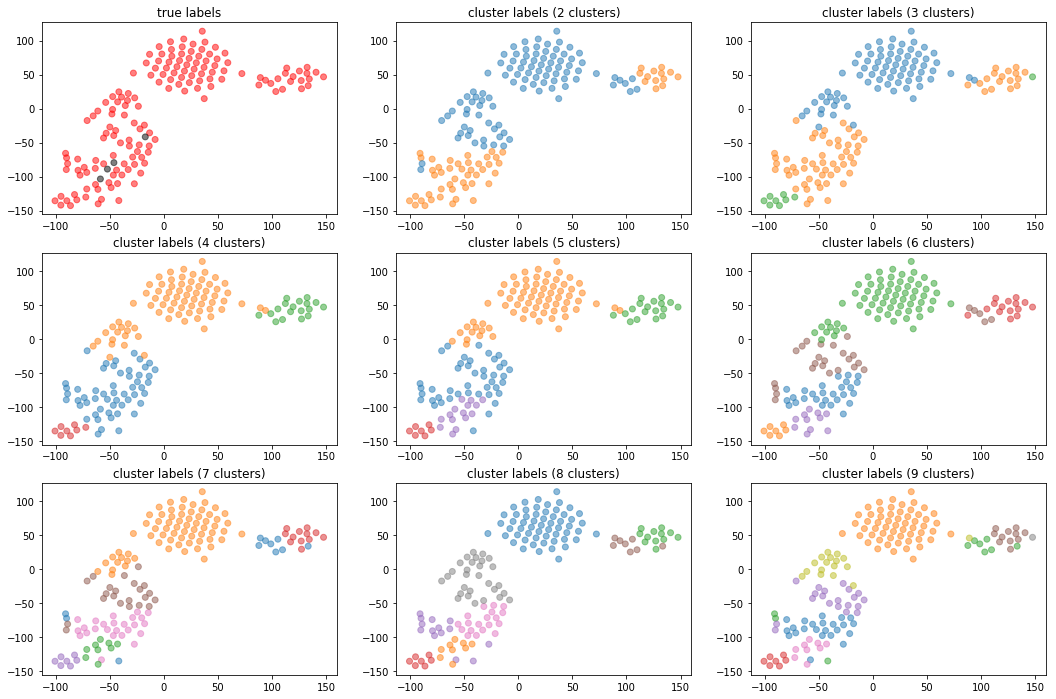

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
6,b'LS I +56 58',B,b' ',b' ',0
7,b'PG 1101+529',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
12,b'MAC 1-490',B,b' ',b'bcu ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
48,b'CPD-58 2614',O,b' ',b' ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
46,b'PG 0042+211',O,b'1FGL J0045.3+2127 ',b'bll ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0
58,b'AzV 236',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
73,b'AzV 216',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
75,b'AzV 233',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
85,b'AzV 228',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
87,b'OGLE SMC-SC8 83095',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
9,b'HD 306182',B,b' ',b'spp ',0
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
41,b'HD 92406',B,b' ',b' ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
61,b'HD 306179',B0Ve,b' ',b'spp ',0
64,b'HD 192039',B0Ve,b' ',b' ',0
67,b'CPD-59 2674',B0Ve,b' ',b' ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
27,b'EC 20443-3134',B,b' ',b' ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
55,b'TYC 3156-998-1',O,b' ',b'SFR ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0
89,b'2MASS J02252738+6203432',B0Ve,b' ',b' ',0
90,b'HD 104705',B0Ve,b' ',b'psr ',0
91,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',1
92,b'HD 330587',B0Ve,b' ',b' ',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
5,b'LS VI -04 15',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
19,b'LS IV -14 70',B,b' ',b' ',0
20,b'LS IV -14 72',B,b' ',b' ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.092436,0.073738,0.096925,0.054256,0.080022,0.0,0.000447,0.001431,0.002891,0.000258,0.001241,0.005839,0.110470,0.192065,0.287339,8.150258e-06,3.583837e-05,1.547701e-04,4.292578e-04,1.297698e-05
1,0.004519,0.030229,0.010703,0.015262,0.033485,0.0,0.023107,0.110542,0.009206,0.000015,0.000000,0.000024,0.000970,0.015057,0.746837,0.000000e+00,6.229425e-06,1.755690e-05,2.015799e-05,0.000000e+00
2,0.107169,0.278209,0.245435,0.126623,0.241477,0.0,0.000071,0.000011,0.000009,0.000002,0.000003,0.000008,0.000212,0.000601,0.000169,6.558511e-10,4.415609e-10,1.724551e-10,8.720713e-11,5.472599e-11
3,0.017892,0.072780,0.091378,0.043027,0.086313,0.0,0.092350,0.036502,0.043914,0.019591,0.022403,0.047866,0.117891,0.135080,0.148806,0.000000e+00,5.834471e-03,8.479837e-03,9.892530e-03,0.000000e+00
4,0.010306,0.099026,0.059815,0.038874,0.135084,0.0,0.051925,0.000143,0.000511,0.000989,0.001588,0.008099,0.049953,0.154017,0.386378,0.000000e+00,4.731003e-05,3.935069e-04,2.850710e-03,0.000000e+00
5,0.033968,0.134799,0.164766,0.084813,0.156866,0.0,0.035231,0.006934,0.013355,0.002910,0.009060,0.014644,0.084940,0.110909,0.140693,2.331861e-09,1.179287e-03,2.114428e-03,2.819326e-03,2.827679e-09


In [8]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(spectra_distances, 300, 1500, 500)
print_clusters_structure(spectra_distances, 6)

* ### euclidean distance

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


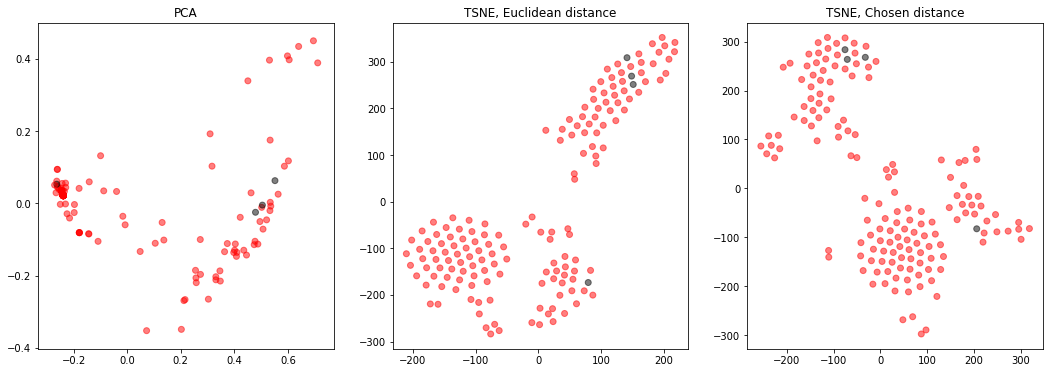

Clustering


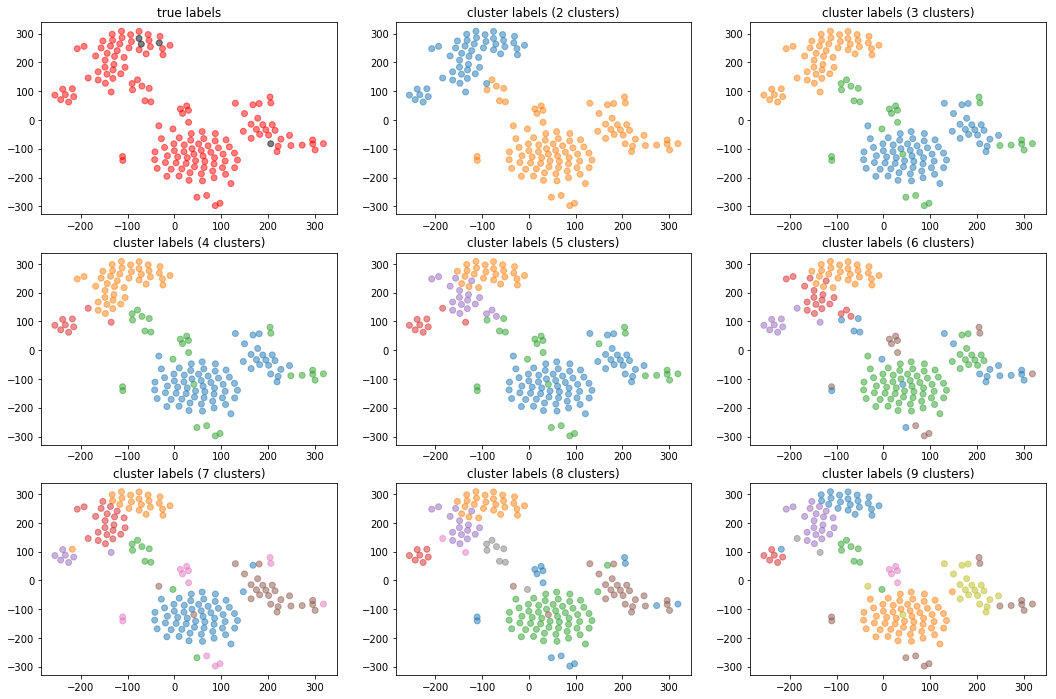

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
7,b'PG 1101+529',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
30,b'SDSS J020438.26+150820.5',B,b'1FGL J0204.5+1516 ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0
33,b'LS IV -05 11',B,b' ',b'PWN ',0
42,b'LS III +60 19',B,b' ',b'spp ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0
54,b'[BKH2005] 16164nr3636',O,b' ',b' ',0
58,b'AzV 236',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
73,b'AzV 216',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
75,b'AzV 233',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
5,b'LS VI -04 15',B,b' ',b' ',0
9,b'HD 306182',B,b' ',b'spp ',0
19,b'LS IV -14 70',B,b' ',b' ',0
31,b'LS II +38 34',B,b' ',b'bcu ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
41,b'HD 92406',B,b' ',b' ',0
43,b'HD 295998',B,b' ',b' ',0
61,b'HD 306179',B0Ve,b' ',b'spp ',0
64,b'HD 192039',B0Ve,b' ',b' ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
48,b'CPD-58 2614',O,b' ',b' ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
90,b'HD 104705',B0Ve,b' ',b'psr ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
20,b'LS IV -14 72',B,b' ',b' ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
74,b'MAC 1-159',B0Ve,b' ',b'bcu ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.047307,0.184481,0.288491,0.115724,0.247938,0.0,0.005419,0.010330,0.008759,4.458879e-03,4.800317e-03,7.561168e-03,0.016688,0.018751,0.039194,1.100611e-05,0.000025,0.000024,0.000021,1.752288e-05
1,0.002300,0.008817,0.006572,0.006019,0.010240,0.0,0.007147,0.003173,0.006890,1.251151e-03,6.910119e-03,1.025863e-02,0.168458,0.302370,0.456499,0.000000e+00,0.000537,0.001044,0.001513,0.000000e+00
2,0.103969,0.281377,0.243268,0.125626,0.244144,0.0,0.000069,0.000013,0.000030,2.568718e-05,4.119650e-06,3.952943e-05,0.000206,0.000680,0.000347,6.368409e-10,0.000007,0.000049,0.000145,5.313973e-11
3,0.005105,0.036119,0.046440,0.019625,0.044163,0.0,0.096594,0.025831,0.039812,1.383286e-02,1.920865e-02,4.577947e-02,0.150713,0.189403,0.243410,0.000000e+00,0.005610,0.008399,0.009955,0.000000e+00
4,0.004793,0.037995,0.008474,0.019810,0.035248,0.0,0.081374,0.086130,0.007589,7.913724e-04,0.000000e+00,9.446563e-03,0.010897,0.023942,0.669453,0.000000e+00,0.000063,0.000495,0.003500,0.000000e+00
5,0.226724,0.202979,0.174444,0.151075,0.209962,0.0,0.021238,0.000041,0.000022,4.243955e-08,1.657923e-07,1.587402e-08,0.000863,0.004964,0.007689,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00


In [9]:
# euclidean distance
from scipy.spatial.distance import euclidean
plt.clf()
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 1000, 1500, 1000)
print_clusters_structure(spectra_distances, 6)

* ### cosine distance

$$ d(u, v) = 1 -  \frac{uv}{||u||_{2}||v||_{2}}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


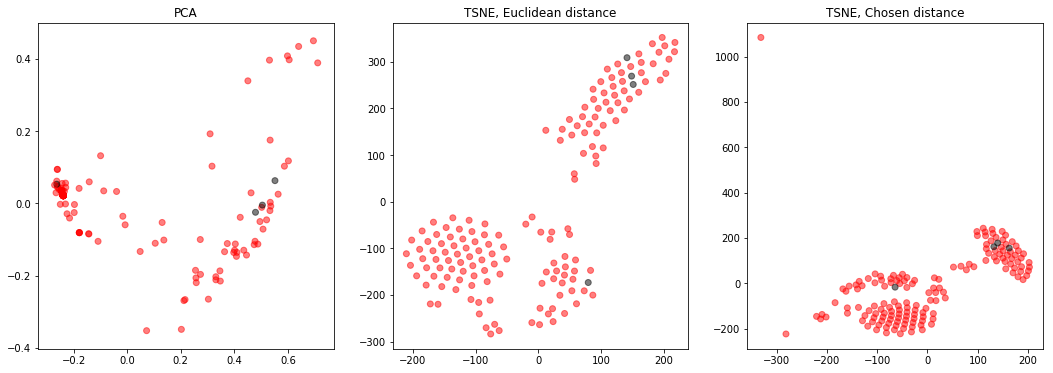

Clustering


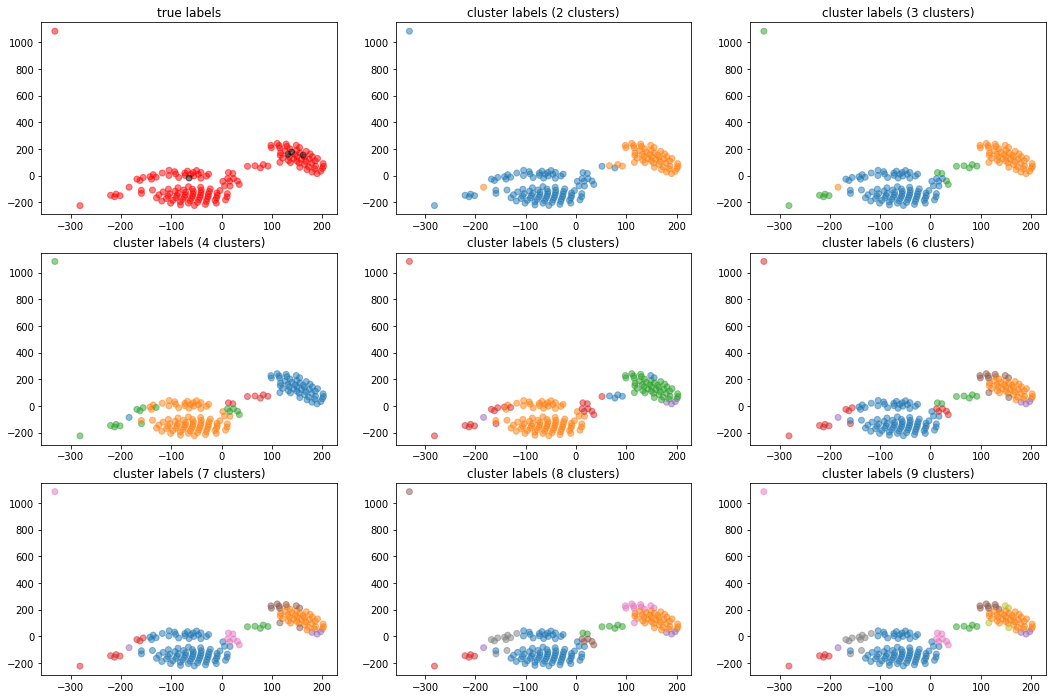

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
7,b'PG 1101+529',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
5,b'LS VI -04 15',B,b' ',b' ',0
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
9,b'HD 306182',B,b' ',b'spp ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
70,b'CPD-59 3179',B0Ve,b' ',b'spp ',0
83,b'UCAC4 146-087591',B0Ve,b'1FGL J1134.8-6055 ',b'PSR ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
74,b'MAC 1-159',B0Ve,b' ',b'bcu ',0
137,b'2E 4673',B0Ve,b' ',b'snr ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
41,b'HD 92406',B,b' ',b' ',0
48,b'CPD-58 2614',O,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0
90,b'HD 104705',B0Ve,b' ',b'psr ',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
68,b'CPD-59 2596',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0
76,b'LS I +62 58',B0Ve,b' ',b' ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


6 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
20,b'LS IV -14 72',B,b' ',b' ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
51,b'GCIRS 8',O,b' ',b' ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0
80,b'2MASS J18444314-0346178',B0Ve,b'1FGL J1844.2-0342c',b' ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.093954,0.266581,0.258229,0.125597,0.247601,0.0,0.000273,0.001346,0.000980,5.566239e-04,3.705743e-04,6.843761e-04,0.000362,0.000721,0.002554,2.652370e-06,1.156249e-05,4.655806e-05,1.255434e-04,4.222317e-06
1,0.002451,0.010760,0.007132,0.006797,0.011295,0.0,0.036307,0.009586,0.016986,5.242324e-03,9.575744e-03,2.169706e-02,0.170188,0.273234,0.411321,0.000000e+00,1.790190e-03,2.594770e-03,3.044936e-03,0.000000e+00
2,0.011945,0.091476,0.169026,0.042566,0.125573,0.0,0.023686,0.023071,0.032107,1.838194e-02,1.816856e-02,3.580011e-02,0.113761,0.133230,0.144866,0.000000e+00,5.503483e-03,4.371568e-03,6.466024e-03,0.000000e+00
3,0.360092,0.094681,0.315546,0.114092,0.114741,0.0,0.000753,0.000061,0.000033,6.365932e-08,2.486884e-07,2.604554e-08,0.000000,0.000000,0.000000,2.439404e-09,2.737052e-09,1.850474e-09,1.340552e-09,1.115022e-09
4,0.000221,0.001381,0.001782,0.000877,0.001365,0.0,0.314875,0.221831,0.053290,1.500863e-02,2.615679e-02,5.960823e-02,0.074011,0.083162,0.092515,0.000000e+00,6.838660e-03,1.832578e-02,2.875127e-02,0.000000e+00
5,0.007929,0.059102,0.042522,0.032462,0.065497,0.0,0.012254,0.004981,0.006799,8.173980e-05,5.593830e-03,7.756611e-03,0.037831,0.075969,0.641221,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,0.016390,0.307767,0.034930,0.171694,0.321476,0.0,0.031120,0.004631,0.003707,6.240599e-05,5.561937e-04,2.613782e-03,0.016211,0.028663,0.060178,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [10]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 1000, 1500, 1000)
print_clusters_structure(spectra_distances, 7)

* ### energy distance

The energy distance between two distributions $u$ and $v$ , whose respective CDFs are $U$ and $V$, equals to: 
$$D(u, v) = (2\mathbb{E}|X-Y| - {E}|X-X'| - {E}|Y-Y'|)^{\frac{1}{2}}$$
where $X$ and $Y$ (resp. $X'$  and $Y'$ ) are independent random variables whose probability distribution is  (resp. ).

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


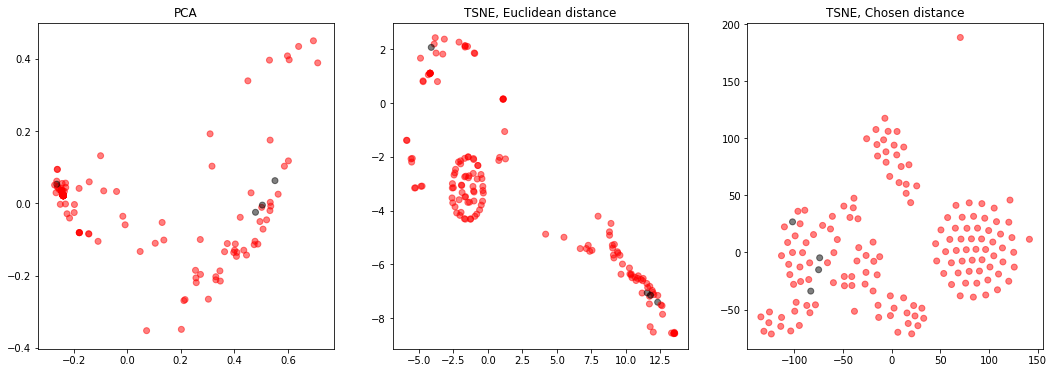

Clustering


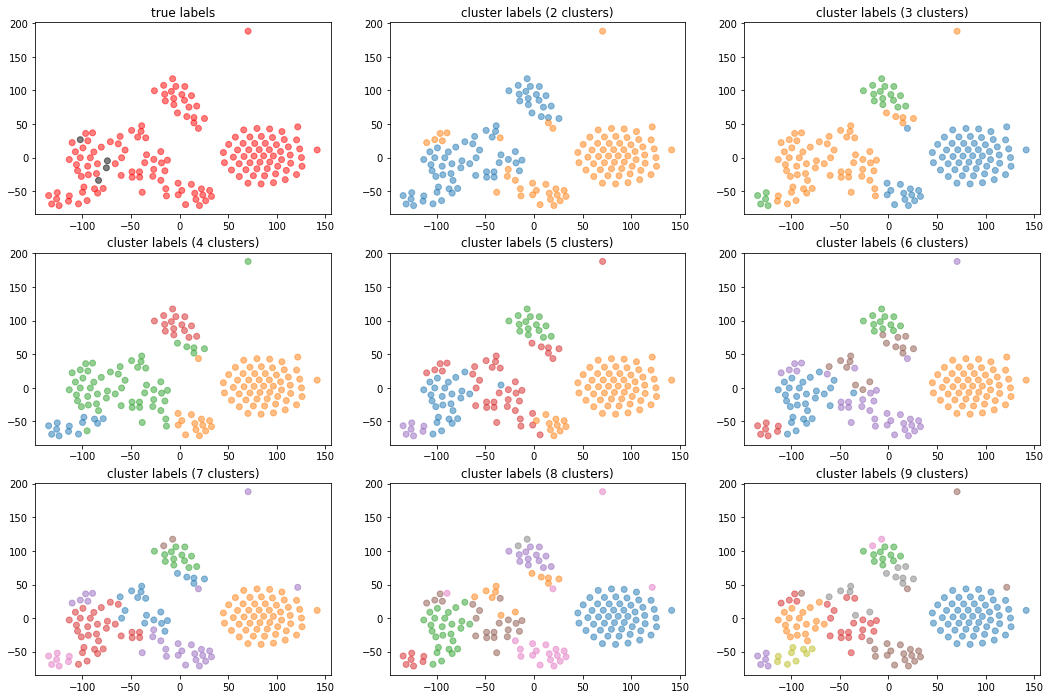

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
20,b'LS IV -14 72',B,b' ',b' ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0
54,b'[BKH2005] 16164nr3636',O,b' ',b' ',0
58,b'AzV 236',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
73,b'AzV 216',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0
75,b'AzV 233',B0Ve,b'1FGL J0101.3-7257 ',b'GAL ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
5,b'LS VI -04 15',B,b' ',b' ',0
6,b'LS I +56 58',B,b' ',b' ',0
7,b'PG 1101+529',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
12,b'MAC 1-490',B,b' ',b'bcu ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
9,b'HD 306182',B,b' ',b'spp ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
41,b'HD 92406',B,b' ',b' ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.103174,0.280677,0.241133,0.126837,0.243237,0.0,0.003675,0.000011,0.000008,0.000002,0.000004,0.000008,0.000206,0.000680,0.000347,6.368409e-10,4.287620e-10,1.674564e-10,8.467938e-11,5.313973e-11
1,0.055215,0.095810,0.118272,0.061998,0.117025,0.0,0.024522,0.015723,0.008374,0.001278,0.002873,0.010349,0.087843,0.148138,0.250573,3.335186e-06,2.339697e-04,5.353412e-04,1.229187e-03,5.309963e-06
2,0.013869,0.055384,0.066701,0.032979,0.061990,0.0,0.062473,0.025898,0.031407,0.015449,0.022550,0.034597,0.094401,0.116662,0.342859,0.000000e+00,5.331338e-03,7.984964e-03,9.464581e-03,0.000000e+00


In [19]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 300, 1500, 600)
print_clusters_structure(spectra_distances, 3)

- ### mahalanobis
$$d(u, v) = \sqrt{(u-v)V^{-1}(u+v)^{T}}$$,
V - The inverse of the covariance matrix.

In [12]:
import scipy as sp
from scipy.spatial.distance import mahalanobis
spectra_ = spectra.drop_duplicates(spectrum_columns)
spectra_spectra = spectra_[spectra_['marked'] != -1]

spectra_no_zeros = spectra_.loc[(spectra_spectra!= 0).any(axis=1), :]
spectra_no_zeros2 = spectra_no_zeros.loc[:, (spectra_no_zeros != 0).any(axis=0)]
new_columns = [i for i in spectra_no_zeros2 if i in spectrum_columns]
covmx = spectra_no_zeros2[new_columns].cov()
invcovmx = sp.linalg.inv(covmx)

In [13]:
spectra_no_zeros2.describe()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,marked
count,1.020000e+02,102.000000,1.020000e+02,102.000000,1.020000e+02,102.000000,102.000000,102.000000,1.020000e+02,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,4.876779e-02,0.111704,1.293022e-01,0.069880,1.292344e-01,0.030603,0.015259,0.011582,3.857129e-03,0.006284,0.013485,0.075489,0.119189,0.229597,0.000002,0.001197,0.001912,0.002651,0.000003,0.039216
std,1.060373e-01,0.115012,1.508304e-01,0.075216,1.332837e-01,0.081508,0.077681,0.020207,1.142321e-02,0.020129,0.022928,0.086569,0.131256,0.257881,0.000022,0.005429,0.008799,0.009385,0.000035,0.195066
min,1.794204e-08,0.000003,3.775132e-09,0.000002,6.679523e-07,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.307772e-04,0.007612,1.027345e-03,0.004094,5.047499e-03,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.690262e-03,0.058323,3.119873e-02,0.035109,9.014605e-02,0.000000,0.000086,0.000263,0.000000e+00,0.000000,0.000131,0.011867,0.068628,0.143300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.640745e-02,0.230854,2.699241e-01,0.122206,2.454983e-01,0.001804,0.005161,0.013429,3.056163e-07,0.000000,0.020146,0.162045,0.251606,0.406320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.763775e-01,0.419141,5.477621e-01,0.314427,5.597534e-01,0.570618,0.773761,0.077391,6.446803e-02,0.106990,0.085406,0.247357,0.353377,0.944818,0.000220,0.033165,0.068975,0.056188,0.000350,1.000000


- ### canberra
$$d(u, v) = \sum_{i} \frac{|u_i - v_i|}{|u_i| + |v_i|}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


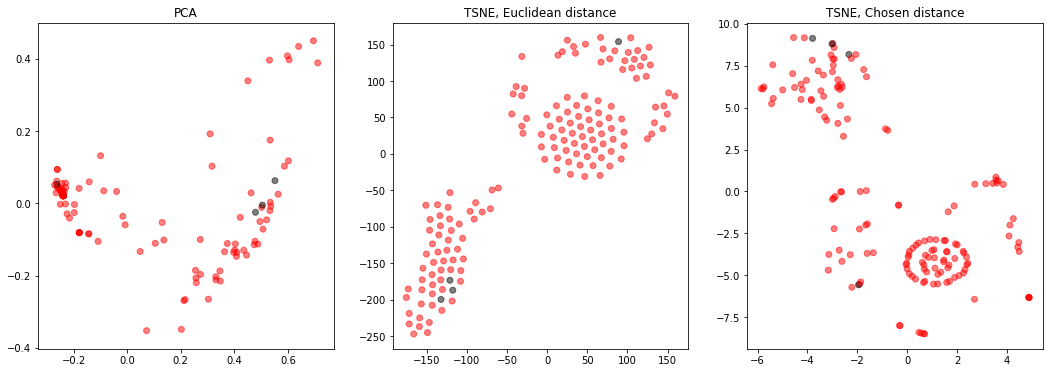

Clustering


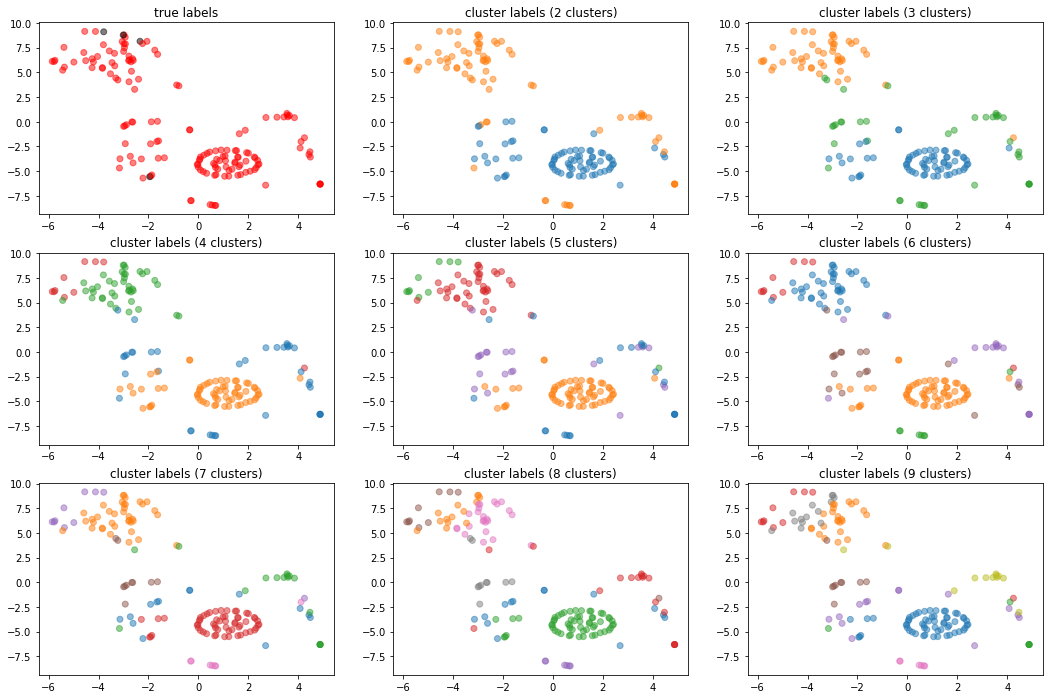

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
20,b'LS IV -14 72',B,b' ',b' ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
51,b'GCIRS 8',O,b' ',b' ',0
52,b'GCIRS 8',O,b'1FGL J1745.6-2900c',b'spp ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
5,b'LS VI -04 15',B,b' ',b' ',0
6,b'LS I +56 58',B,b' ',b' ',0
9,b'HD 306182',B,b' ',b'spp ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
12,b'MAC 1-490',B,b' ',b'bcu ',0
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
46,b'PG 0042+211',O,b'1FGL J0045.3+2127 ',b'bll ',0
48,b'CPD-58 2614',O,b' ',b' ',0
56,b'BI 23',B0Ve,b' ',b'pwn ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0
54,b'[BKH2005] 16164nr3636',O,b' ',b' ',0
93,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
94,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
95,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
96,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
97,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
98,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
7,b'PG 1101+529',B,b' ',b' ',0
41,b'HD 92406',B,b' ',b' ',0
60,b'HD 326775',B0Ve,b' ',b' ',0
67,b'CPD-59 2674',B0Ve,b' ',b' ',0
71,b'CPD-58 2649',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
72,b'CD-59 3472',B0Ve,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0
90,b'HD 104705',B0Ve,b' ',b'psr ',0
146,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',1


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
80,b'2MASS J18444314-0346178',B0Ve,b'1FGL J1844.2-0342c',b' ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


6 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
10,b'GSC 05698-00468',B,b' ',b'spp ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
30,b'SDSS J020438.26+150820.5',B,b'1FGL J0204.5+1516 ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
37,b'SDSS J065306.66+281832.1',B,b' ',b'bcu ',0
38,b'SDSS J232339.56-031507.7',B,b'1FGL J2323.5-0315 ',b'fsrq ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.084330,0.243062,0.212714,0.148111,0.264535,0.0,0.018204,0.000041,0.001160,0.000000,2.189572e-13,0.000000,0.000989,0.002875,0.023979,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
1,0.004187,0.024426,0.025242,0.014593,0.027682,0.0,0.034434,0.011522,0.019842,0.005652,9.809953e-03,0.024322,0.164839,0.261341,0.369956,0.000000e+00,0.000724,0.000575,0.000851,0.000000e+00
2,0.156616,0.164041,0.241303,0.122862,0.218529,0.0,0.010851,0.052065,0.007532,0.002631,2.071130e-03,0.003221,0.003309,0.005588,0.009380,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
3,0.107833,0.288490,0.242002,0.120333,0.241341,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
4,0.000431,0.017391,0.045410,0.008827,0.040523,0.0,0.137368,0.015977,0.022363,0.013225,2.329326e-02,0.033739,0.116597,0.170281,0.305322,2.200565e-05,0.009408,0.016978,0.022809,3.503764e-05
5,0.010780,0.108227,0.062456,0.066573,0.093137,0.0,0.000000,0.007299,0.005798,0.000000,0.000000e+00,0.005695,0.019990,0.038824,0.581222,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
6,0.080588,0.200146,0.340286,0.133264,0.242953,0.0,0.000000,0.000023,0.000211,0.000237,0.000000e+00,0.000311,0.000000,0.000000,0.000000,1.566588e-08,0.000067,0.000484,0.001429,1.211339e-08


In [14]:
metric_function = "canberra"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 7)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


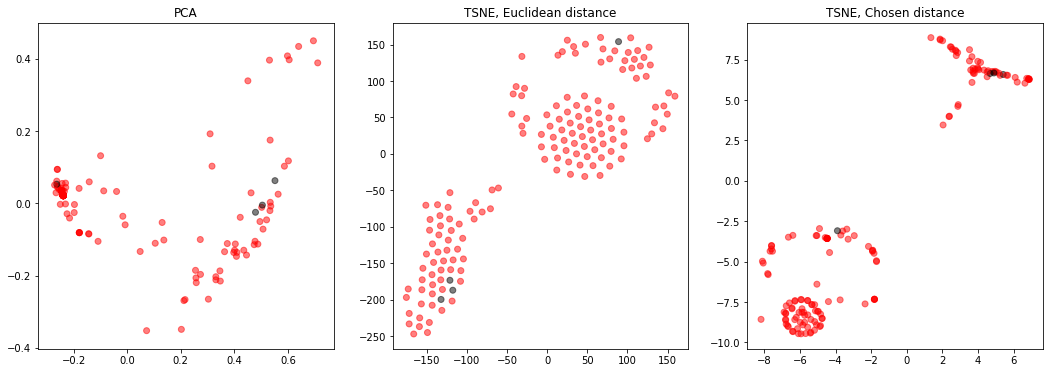

Clustering


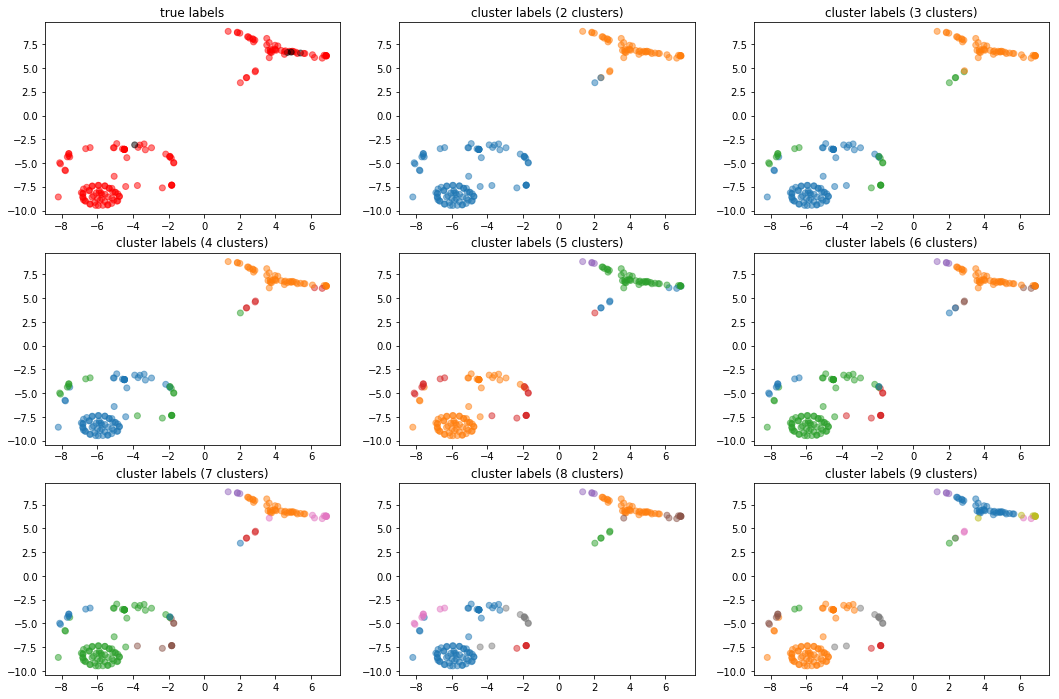

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
20,b'LS IV -14 72',B,b' ',b' ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
51,b'GCIRS 8',O,b' ',b' ',0
52,b'GCIRS 8',O,b'1FGL J1745.6-2900c',b'spp ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0
80,b'2MASS J18444314-0346178',B0Ve,b'1FGL J1844.2-0342c',b' ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
7,b'PG 1101+529',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
9,b'HD 306182',B,b' ',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
70,b'CPD-59 3179',B0Ve,b' ',b'spp ',0
83,b'UCAC4 146-087591',B0Ve,b'1FGL J1134.8-6055 ',b'PSR ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
41,b'HD 92406',B,b' ',b' ',0
48,b'CPD-58 2614',O,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0
90,b'HD 104705',B0Ve,b' ',b'psr ',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
74,b'MAC 1-159',B0Ve,b' ',b'bcu ',0
137,b'2E 4673',B0Ve,b' ',b'snr ',0


6 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
68,b'CPD-59 2596',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
89,b'2MASS J02252738+6203432',B0Ve,b' ',b' ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.019592,0.266712,0.099653,0.150167,0.293406,0.0,0.024896,0.007306,0.005826,0.000050,0.000445,0.005760,0.023621,0.032513,0.070053,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.002515,0.011415,0.008070,0.007227,0.011369,0.0,0.040218,0.011119,0.019051,0.005385,0.009842,0.023988,0.178226,0.278343,0.385604,0.000000e+00,1.838706e-03,2.663434e-03,3.125598e-03,0.000000e+00
2,0.093776,0.269945,0.257146,0.125793,0.250434,0.0,0.000280,0.000043,0.000252,0.000026,0.000020,0.000063,0.000206,0.000625,0.001197,2.717860e-06,1.184798e-05,4.770764e-05,1.286432e-04,4.326572e-06
3,0.011717,0.092763,0.138233,0.050269,0.111678,0.0,0.029608,0.019836,0.032982,0.022977,0.022711,0.035578,0.115570,0.142584,0.153068,0.000000e+00,6.879354e-03,5.464460e-03,8.082530e-03,0.000000e+00
4,0.000221,0.001381,0.001782,0.000877,0.001365,0.0,0.314875,0.221831,0.053290,0.015009,0.026157,0.059608,0.074011,0.083162,0.092515,0.000000e+00,6.838660e-03,1.832578e-02,2.875127e-02,0.000000e+00
5,0.336789,0.099945,0.300405,0.114632,0.111396,0.0,0.000670,0.012084,0.006794,0.004901,0.003238,0.005742,0.001487,0.001024,0.000892,2.168359e-09,2.432935e-09,1.644865e-09,1.191601e-09,9.911310e-10
6,0.007221,0.052562,0.036233,0.028720,0.060327,0.0,0.001643,0.000382,0.000964,0.000084,0.005085,0.001525,0.023557,0.077183,0.704486,0.000000e+00,3.964180e-06,1.117257e-05,1.282781e-05,0.000000e+00


In [15]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 7)

- ### cityblock
$$ d(u, v) = \sum_{i} |u_i - v_i|$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


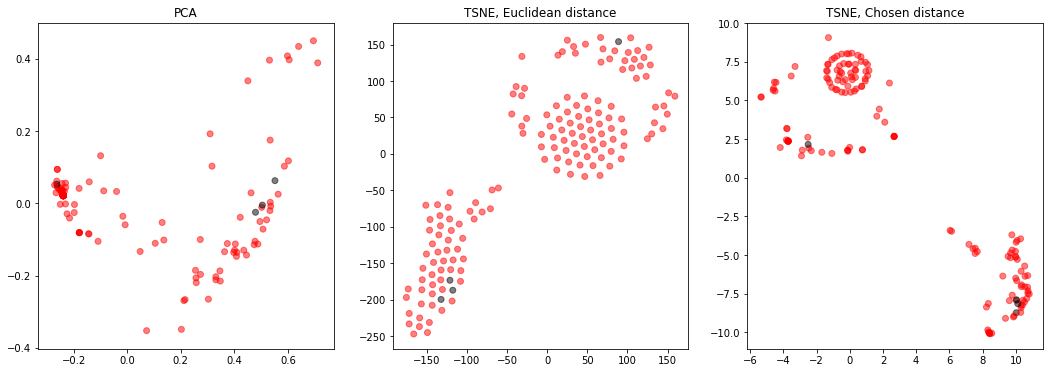

Clustering


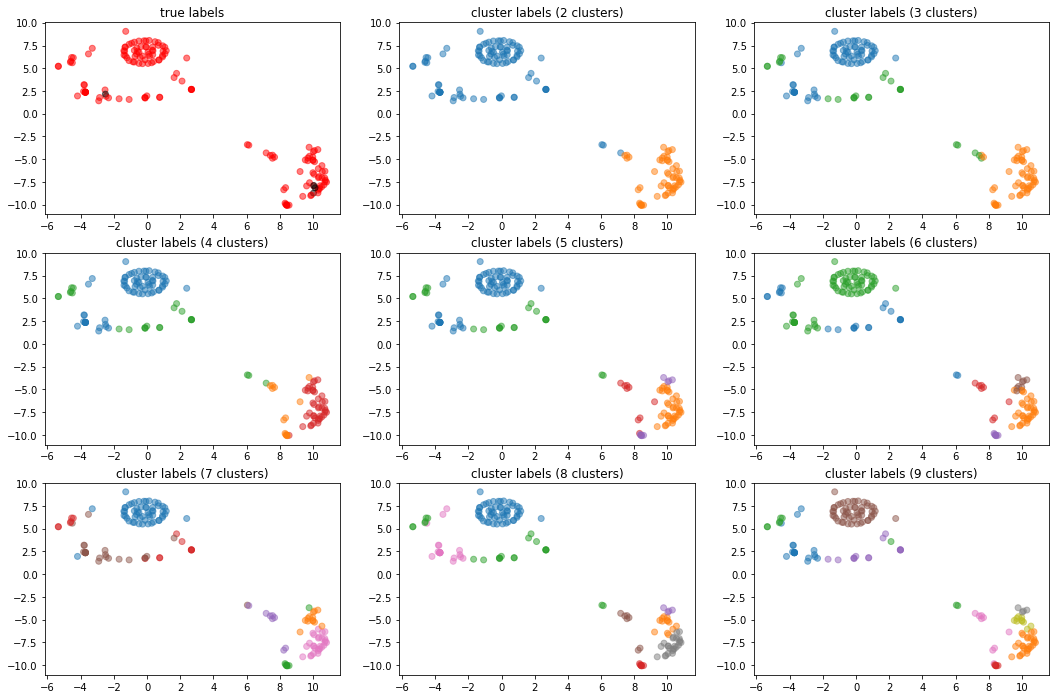

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
54,b'[BKH2005] 16164nr3636',O,b' ',b' ',0
93,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
94,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
95,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
96,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
97,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
98,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
99,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
100,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
41,b'HD 92406',B,b' ',b' ',0
43,b'HD 295998',B,b' ',b' ',0
61,b'HD 306179',B0Ve,b' ',b'spp ',0
64,b'HD 192039',B0Ve,b' ',b' ',0
67,b'CPD-59 2674',B0Ve,b' ',b' ',0
68,b'CPD-59 2596',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
72,b'CD-59 3472',B0Ve,b' ',b' ',0
76,b'LS I +62 58',B0Ve,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
48,b'CPD-58 2614',O,b' ',b' ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
20,b'LS IV -14 72',B,b' ',b' ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
51,b'GCIRS 8',O,b' ',b' ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
9,b'HD 306182',B,b' ',b'spp ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0
70,b'CPD-59 3179',B0Ve,b' ',b'spp ',0
83,b'UCAC4 146-087591',B0Ve,b'1FGL J1134.8-6055 ',b'PSR ',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
7,b'PG 1101+529',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0


6 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0
31,b'LS II +38 34',B,b' ',b'bcu ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.115396,0.289371,0.241405,0.121391,0.231304,0.0,5.415178e-15,2.155823e-14,2.165871e-08,0.000000,5.377897e-14,4.660779e-11,0.000243,0.000701,0.000189,9.199369e-12,6.946376e-11,4.283110e-11,2.563054e-11,1.491966e-11
1,0.001889,0.015855,0.013734,0.007940,0.016350,0.0,1.815463e-01,3.088783e-02,4.599649e-02,0.017028,2.546252e-02,6.107044e-02,0.161372,0.185921,0.203423,0.000000e+00,6.122011e-03,1.092670e-02,1.447525e-02,0.000000e+00
2,0.005392,0.042738,0.009522,0.022284,0.039645,0.0,2.021858e-02,9.672465e-02,8.054971e-03,0.000013,0.000000e+00,2.129394e-05,0.000850,0.014738,0.739761,0.000000e+00,5.450747e-06,1.536229e-05,1.763824e-05,0.000000e+00
3,0.207657,0.199952,0.182363,0.143480,0.207106,0.0,1.699021e-02,7.250493e-03,4.076535e-03,0.002941,1.942892e-03,3.445245e-03,0.001582,0.004587,0.016626,1.301016e-09,1.459761e-09,9.869193e-10,7.149608e-10,5.946786e-10
4,0.012443,0.097463,0.149725,0.056365,0.131000,0.0,1.480927e-02,1.904496e-02,2.376068e-02,0.011591,1.187936e-02,2.498570e-02,0.088604,0.127848,0.220268,0.000000e+00,3.439677e-03,2.732230e-03,4.041265e-03,0.000000e+00
5,0.042435,0.218095,0.294532,0.134383,0.289750,0.0,8.766773e-04,1.363746e-04,7.962913e-04,0.000100,2.333009e-04,2.220715e-04,0.001714,0.003397,0.012721,8.467160e-06,3.691086e-05,1.486276e-04,4.007730e-04,1.347890e-05
6,0.002773,0.010938,0.006153,0.007335,0.012309,0.0,7.268517e-03,4.158768e-03,8.822898e-03,0.001162,6.416539e-03,1.157430e-02,0.171580,0.300091,0.446547,0.000000e+00,4.986396e-04,9.692721e-04,1.405301e-03,0.000000e+00


In [16]:
metric_function = "cityblock"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 7)

- ### braycurtis $$d(u, v) = \frac{\sum_{i} |u_i - v_i|}{\sum_{i}|u_i + v_i|}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


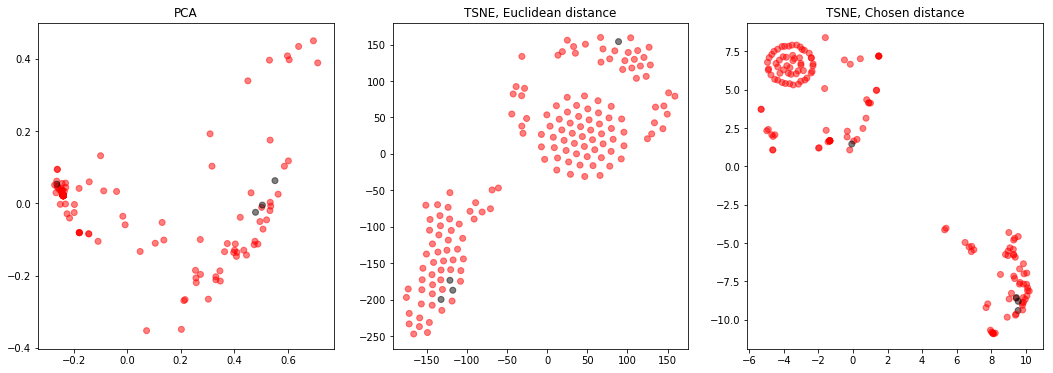

Clustering


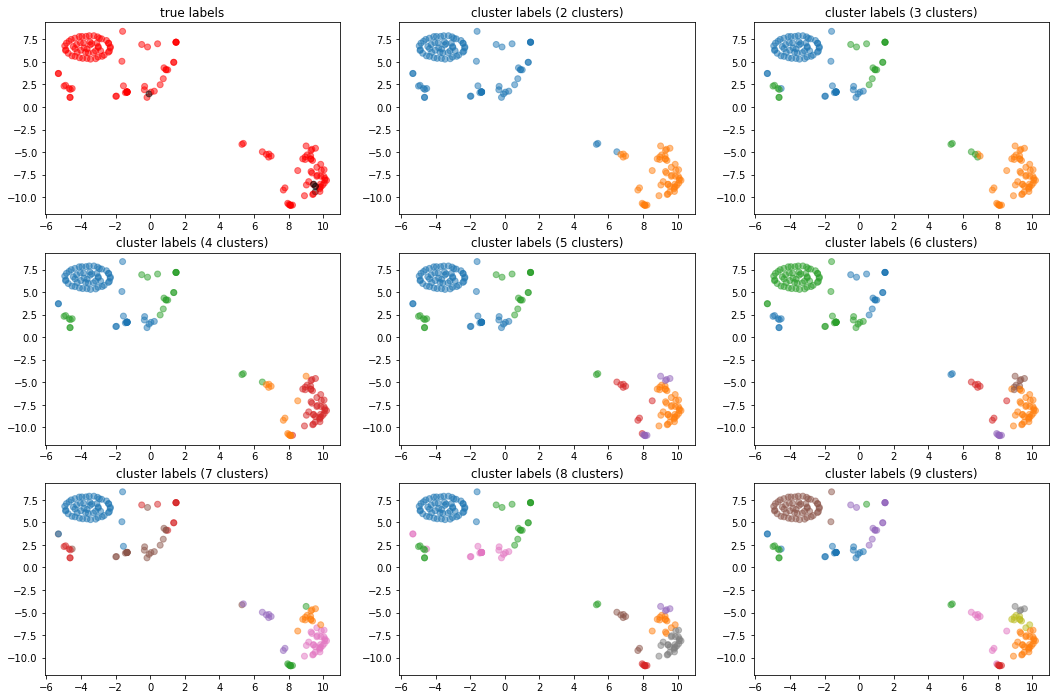

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
54,b'[BKH2005] 16164nr3636',O,b' ',b' ',0
93,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
94,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
95,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
96,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
97,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
98,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
99,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0
100,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
41,b'HD 92406',B,b' ',b' ',0
43,b'HD 295998',B,b' ',b' ',0
61,b'HD 306179',B0Ve,b' ',b'spp ',0
64,b'HD 192039',B0Ve,b' ',b' ',0
67,b'CPD-59 2674',B0Ve,b' ',b' ',0
68,b'CPD-59 2596',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
72,b'CD-59 3472',B0Ve,b' ',b' ',0
76,b'LS I +62 58',B0Ve,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
48,b'CPD-58 2614',O,b' ',b' ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
142,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
20,b'LS IV -14 72',B,b' ',b' ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
51,b'GCIRS 8',O,b' ',b' ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
9,b'HD 306182',B,b' ',b'spp ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0
70,b'CPD-59 3179',B0Ve,b' ',b'spp ',0
83,b'UCAC4 146-087591',B0Ve,b'1FGL J1134.8-6055 ',b'PSR ',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
7,b'PG 1101+529',B,b' ',b' ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0


6 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0
31,b'LS II +38 34',B,b' ',b'bcu ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.115396,0.289371,0.241405,0.121391,0.231304,0.0,5.415178e-15,2.155823e-14,2.165871e-08,0.000000,5.377897e-14,4.660779e-11,0.000243,0.000701,0.000189,9.199369e-12,6.946376e-11,4.283110e-11,2.563054e-11,1.491966e-11
1,0.001889,0.015855,0.013734,0.007940,0.016350,0.0,1.815463e-01,3.088783e-02,4.599649e-02,0.017028,2.546252e-02,6.107044e-02,0.161372,0.185921,0.203423,0.000000e+00,6.122011e-03,1.092670e-02,1.447525e-02,0.000000e+00
2,0.005392,0.042738,0.009522,0.022284,0.039645,0.0,2.021858e-02,9.672465e-02,8.054971e-03,0.000013,0.000000e+00,2.129394e-05,0.000850,0.014738,0.739761,0.000000e+00,5.450747e-06,1.536229e-05,1.763824e-05,0.000000e+00
3,0.207657,0.199952,0.182363,0.143480,0.207106,0.0,1.699021e-02,7.250493e-03,4.076535e-03,0.002941,1.942892e-03,3.445245e-03,0.001582,0.004587,0.016626,1.301016e-09,1.459761e-09,9.869193e-10,7.149608e-10,5.946786e-10
4,0.012443,0.097463,0.149725,0.056365,0.131000,0.0,1.480927e-02,1.904496e-02,2.376068e-02,0.011591,1.187936e-02,2.498570e-02,0.088604,0.127848,0.220268,0.000000e+00,3.439677e-03,2.732230e-03,4.041265e-03,0.000000e+00
5,0.042435,0.218095,0.294532,0.134383,0.289750,0.0,8.766773e-04,1.363746e-04,7.962913e-04,0.000100,2.333009e-04,2.220715e-04,0.001714,0.003397,0.012721,8.467160e-06,3.691086e-05,1.486276e-04,4.007730e-04,1.347890e-05
6,0.002773,0.010938,0.006153,0.007335,0.012309,0.0,7.268517e-03,4.158768e-03,8.822898e-03,0.001162,6.416539e-03,1.157430e-02,0.171580,0.300091,0.446547,0.000000e+00,4.986396e-04,9.692721e-04,1.405301e-03,0.000000e+00


In [17]:
metric_function = "braycurtis"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 7)

- ### corellation 
$$d(u, v) = 1 -  \frac{(u - \overline{u}) \cdot (v - \overline{v})}{||(u - \overline{u})||_{2} \cdot  ||(v - \overline{v})||_{2}}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


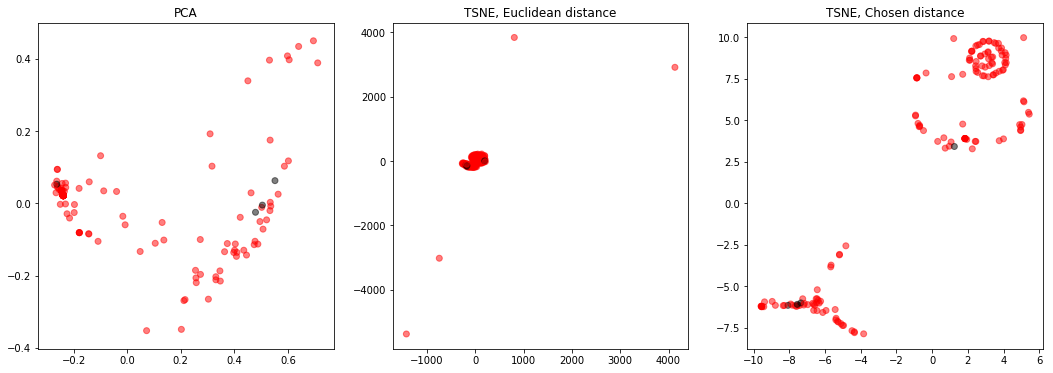

Clustering


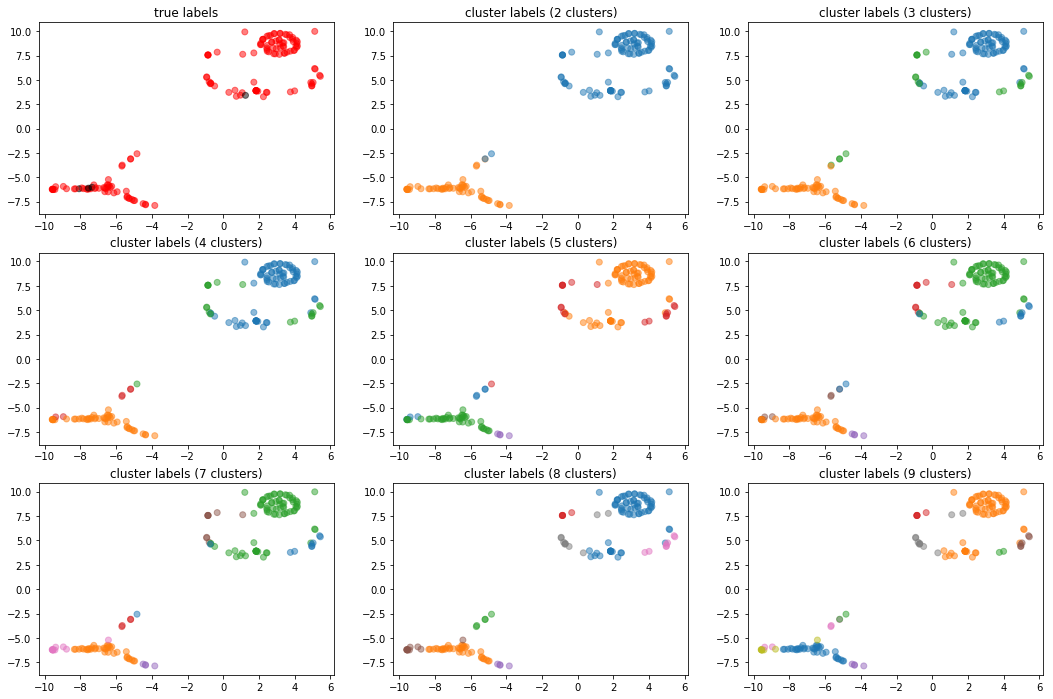

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
0,b'[KRL2007b] 194',Be,b'1FGL J1636.4-4737c',b'snr ',0
4,b'LIN 341',Be,b'1FGL J0101.3-7257 ',b'GAL ',0
8,b'GALEX J175340.5-500741',B,b'1FGL J1754.0-5002 ',b'bcu ',0
10,b'GSC 05698-00468',B,b' ',b'spp ',0
18,b'SDSS J085023.10+485826.3',B,b'1FGL J0849.9+4852 ',b'bll ',0
22,b'SDSS J104238.64+240826.6',B,b'1FGL J1043.1+2404 ',b'fsrq ',0
24,b'LS III +50 6',B,b'1FGL J2046.0+4954 ',b'SNR ',0
29,b'DETWC Tr 16 J104445.3-593920',B,b'1FGL J1045.2-5942 ',b'BIN ',0
38,b'SDSS J232339.56-031507.7',B,b'1FGL J2323.5-0315 ',b'fsrq ',0
47,b'LLNS 2720',O,b'1FGL J1045.2-5942 ',b'BIN ',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
5,b'LS VI -04 15',B,b' ',b' ',0
6,b'LS I +56 58',B,b' ',b' ',0
11,b'EM* GGA 394',B,b' ',b'spp ',0
13,b'LS IV -03 6',B,b'1FGL J1842.9-0359c',b' ',0
15,b'BD-14 5057',B,b' ',b' ',0
17,b'EM* GGR 129',B,b' ',b' ',0
19,b'LS IV -14 70',B,b' ',b' ',0
21,b'CPD-58 2608B',B,b' ',b' ',0
23,b'Hen 3-1611',B,b' ',b'spp ',0
25,b'LS III +45 57',B,b'1FGL J2111.3+4607 ',b'PSR ',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
9,b'HD 306182',B,b' ',b'spp ',0
16,b'TYC 8958-1269-1',B,b' ',b'PSR ',0
39,b'TYC 8958-3477-1',B,b' ',b'PSR ',0
70,b'CPD-59 3179',B0Ve,b' ',b'spp ',0
83,b'UCAC4 146-087591',B0Ve,b'1FGL J1134.8-6055 ',b'PSR ',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
12,b'MAC 1-490',B,b' ',b'bcu ',0
32,b'LGGS J004032.13+404522.5',B,b' ',b'bcu ',0
40,b'MAC 1-531',B,b' ',b'bcu ',0
74,b'MAC 1-159',B0Ve,b' ',b'bcu ',0
137,b'2E 4673',B0Ve,b' ',b'snr ',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
41,b'HD 92406',B,b' ',b' ',0
48,b'CPD-58 2614',O,b' ',b' ',0
82,b'HD 306181',B0Ve,b' ',b'spp ',0
90,b'HD 104705',B0Ve,b' ',b'psr ',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
1,b'HD 328990',Be,b'1FGL J1651.5-4602c',b' ',0
2,b'UCAC2 5051621',Be,b' ',b'spp ',0
35,b'GCIRS 1W',B,b' ',b' ',0
36,b'GCIRS 1W',B,b'1FGL J1745.6-2900c',b'spp ',0
49,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',0
53,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',0
68,b'CPD-59 2596',B0Ve,b'1FGL J1045.2-5942 ',b'BIN ',0
69,b'[LCL2005b] G305.3+0.2 A2',B0Ve,b' ',b' ',0
79,b'2MASS J02254709+6206131',B0Ve,b' ',b' ',0
89,b'2MASS J02252738+6203432',B0Ve,b' ',b' ',0


6 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
14,b'Cl Trumpler 16 215',B,b'1FGL J1045.2-5942 ',b'BIN ',0
20,b'LS IV -14 72',B,b' ',b' ',0
26,b'TYC 158-2839-1',B,b' ',b'spp ',0
50,b'[MCF2015] 22',O,b' ',b' ',0
51,b'GCIRS 8',O,b' ',b' ',0
77,b'BBRW W3 (c)',B0Ve,b' ',b' ',0
78,b'[WBN72] W 3 IRS 2b',B0Ve,b' ',b' ',0
80,b'2MASS J18444314-0346178',B0Ve,b'1FGL J1844.2-0342c',b' ',0


7 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,marked
3,b'SSTGC 519103',Be,b'1FGL J1745.6-2900c',b'spp ',0
7,b'PG 1101+529',B,b' ',b' ',0
27,b'EC 20443-3134',B,b' ',b' ',0
28,b'EC 19516-5652',B,b' ',b'bcu ',0
30,b'SDSS J020438.26+150820.5',B,b'1FGL J0204.5+1516 ',b'bcu ',0
34,b'SDSS J134029.74+441346.8',B,b'1FGL J1340.6+4406 ',b'bll ',0
37,b'SDSS J065306.66+281832.1',B,b' ',b'bcu ',0
44,b'TYC 9044-1653-1',B,b' ',b'bll ',0
46,b'PG 0042+211',O,b'1FGL J0045.3+2127 ',b'bll ',0
52,b'GCIRS 8',O,b'1FGL J1745.6-2900c',b'spp ',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z
0,0.095431,0.278235,0.248126,0.124191,0.251972,0.0,2.981232e-04,4.257305e-05,2.627101e-04,2.332125e-05,2.126677e-05,6.029648e-05,0.000198,0.000632,0.000325,1.096872e-09,0.000006,0.000045,0.000132,6.982337e-10
1,0.002515,0.011415,0.008070,0.007227,0.011369,0.0,4.021777e-02,1.111876e-02,1.905126e-02,5.385105e-03,9.841737e-03,2.398826e-02,0.178226,0.278343,0.385604,0.000000e+00,0.001839,0.002663,0.003126,0.000000e+00
2,0.011945,0.091476,0.169026,0.042566,0.125573,0.0,2.368645e-02,2.307148e-02,3.210652e-02,1.838194e-02,1.816856e-02,3.580011e-02,0.113761,0.133230,0.144866,0.000000e+00,0.005503,0.004372,0.006466,0.000000e+00
3,0.470128,0.094530,0.215940,0.120033,0.099367,0.0,7.822616e-07,1.125963e-07,7.795131e-08,1.018549e-07,3.979015e-07,3.809764e-08,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
4,0.000221,0.001381,0.001782,0.000877,0.001365,0.0,3.148750e-01,2.218311e-01,5.329002e-02,1.500863e-02,2.615679e-02,5.960823e-02,0.074011,0.083162,0.092515,0.000000e+00,0.006839,0.018326,0.028751,0.000000e+00
5,0.007221,0.052562,0.036233,0.028720,0.060327,0.0,1.642839e-03,3.824696e-04,9.644362e-04,8.360185e-05,5.085300e-03,1.525477e-03,0.023557,0.077183,0.704486,0.000000e+00,0.000004,0.000011,0.000013,0.000000e+00
6,0.016390,0.307767,0.034930,0.171694,0.321476,0.0,3.112021e-02,4.631185e-03,3.706688e-03,6.240599e-05,5.561937e-04,2.613782e-03,0.016211,0.028663,0.060178,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
7,0.107553,0.126524,0.402007,0.129855,0.182207,0.0,6.023736e-04,1.089973e-02,6.160702e-03,4.442737e-03,2.914139e-03,5.222070e-03,0.001507,0.001176,0.018734,2.200828e-05,0.000049,0.000047,0.000042,3.504082e-05


In [18]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 8)